# Pipeline MRTrix 0.2 tractography workflow

This workflow has to be connected straight subsequentially to the <b>MRTrix 0.2 preprocessing workflow</b>.
Continuing on the files generated by it's predecessor, this workflow will perform the actual fiber tracking for a <b>single seed mask</b>. Thus it will generate a single tractograpy file and it intended to be run in parallel by a surounding scaffold workflow.

In [2]:
import nipype.interfaces.mrtrix as mrt
import numpy as np
from nipype import Node, Workflow, MapNode, Function
from nipype.interfaces.utility import IdentityInterface

import logging, re

### Start the logging

In [3]:
logger = logging.getLogger('interface')
logger.setLevel(logging.INFO)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

### Define Input- and Output-Node

In [4]:
inputNode = MapNode(IdentityInterface(fields = ['wmmask_1mm',
                                            'spherical_harmonics_image',
                                            'seedmask',
                                            'targetmask',
                                            'seed_count',
                                            'delete_tmp_files',
                                            'tracks_dir']), 
                    name = 'input_node',
                    iterfield = ['seedmask', 'targetmask', 'seed_count'])

outputNode = Node(IdentityInterface(fields = ['tck_file']), 
                  name = 'output_node')

### Utility functions

In [15]:
def getSeedmaskIndex(seedmask):
    res = re.search("\d{4,999}", seedmask)
    return res.group()

def fileNameBuild(path, seedmask):
    seedMskIdx = getSeedmaskIndex(seedmask)
    return path + '/' + seedMskIdx + '_tracks.tck'

def fileNameBuildTRK(path, seedmask):
    seedMskIdx = getSeedmaskIndex(seedmask)
    return path + '/' + seedMskIdx + '_tracks.trk'

### Perform the fiber tracking

In [6]:
trackingNode = Node(mrt.StreamlineTrack(), name = 'tracking_node')
trackingNode.inputs.inputmodel = 'SD_PROB'
trackingNode.inputs.minimum_tract_length = 30 #Min length set to 30mm here
trackingNode.inputs.stop = True
trackingNode.inputs.no_mask_interpolation = True
trackingNode.inputs.unidirectional = True


### Convert tck to trk

In [12]:
# Now we convert the resulting tck file from the hard drive into a Trackvis trk file
# By default, the tck is then deleted to save storage space. This parameter can be overwritten
# The reason for this is simply that we want to obtain files having the sama data schema independent from 
# the particullar toolbox choosen for tracktography
#
def convert2trk(tck_file, image_file, output_file, delete_tmp_files=None):
    import nipype.interfaces.mrtrix as mrt
    import os
    # Convert to trk
    tck2trk = mrt.convert.MRTrix2TrackVis()
    tck2trk.inputs.in_file = tck_file
    tck2trk.inputs.image_file = image_file
    tck2trk.inputs.out_filename = output_file
    tck2trk.run()
    # Delete tmp files if needed (default is yes)
    if delete_tmp_files is None:
        os.remove(tck_file)
        
    return output_file
        
convertNode = Node(Function(input_names = ['tck_file', 'image_file', 'output_file', 'delete_tmp_files'],
                            output_names = ['output_file'],
                           function = convert2trk),
                   name = 'tck2trk')

### Define the workflow

In [16]:
wf = Workflow('MRTRIX_tracking')

wf.connect([
        (inputNode, trackingNode, [('spherical_harmonics_image', 'in_file'),
                                  ('seedmask', 'seed_file'),
                                  ('targetmask', 'include_file'),
                                  ('wmmask_1mm', 'mask_file'),
                                  ('seed_count', 'desired_number_of_tracks'),
                                  (('tracks_dir', fileNameBuild, 'seedmask'), 'out_file')]),
        (trackingNode, convertNode, [('tracked', 'tck_file')]),
        (inputNode, convertNode, [('seedmask', 'image_file'),
                                 (('tracks_dir', fileNameBuildTRK, 'seedmask'), 'output_file')]),
        (convertNode, outputNode, [('output_file', 'tck_file')])
    ])

INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/mrtrix/workflow_graph.dot to png format


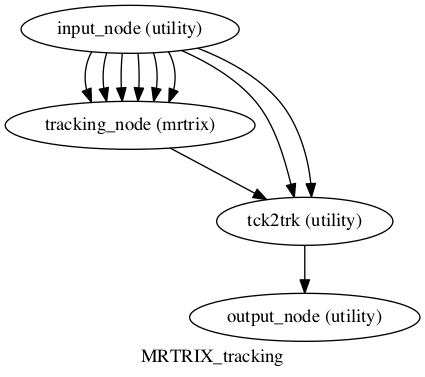

In [17]:
#wf.write_graph("workflow_graph.dot")
#from IPython.display import Image
#Image(filename="workflow_graph.dot.png")